# 2.2 Linear regression

By the end of this notebook you should be able to:

- Model a *nonlinear* response with a linear model (e.g. polynomial regression)
- Understand the idea of *overfitting* and *underfitting*
- Understand how to carry out *cross-validation*
- Understand what *regularized* least squares regression is
- Understand how weights in linear regression can be used to remove features (feature selection)

## Nonlinear response (with a linear model)

The second restriction of simple linear regression we mentioned earlier was: *Restricting ourselves to a linear function of the features may not be appropriate.*

To simplify discussion, suppose we still only have one feature $x$, and that the relationship between $x$ and $y$ looks quadratic.
 
In this case, we would want to capture this relationship by adding an extra term $x^2$ to our model:

\begin{equation} f(x) = w_0 + w_1x + w_2x^2 \end{equation}

More generally however, we may want to add polynomial terms up to order $M$:

\begin{equation} f(x) = \sum_{i=0}^{M} w_i x^i = w_0 + w_1x + w_2x^2 + \ldots w_Mx^M \end{equation}

In this case, we can view the $x^i$ terms as additional features, and therefore the problem becomes one of multiple linear regression.

For a $M$-th order polynomial, the design matrix becomes:

\begin{equation} \mathbf{X} = \begin{bmatrix} \mathbf{x}_1^T \\ \mathbf{x}_2^T \\ \vdots \\ \mathbf{x}_N^T \end{bmatrix} = \begin{bmatrix} 1 & x_{1} & x_{1}^2 & x_{1}^3 & \ldots & x_{1}^M \\ 1 & x_{2} & x_{2}^2 & x_{2}^3 & \ldots & x_{2}^M\\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{N} & x_{N}^2 & x_{N}^3 & \ldots & x_{N}^M \end{bmatrix} \end{equation}

where here $x_i^j$ means feature $x$ from example $i$ is raised to the power of $j$

This is called the **Vandermonde matrix**.

![FromSimpleToPoly](Images/simple_to_poly2_cite.png)

We have already covered everything we need to implement polynomial regression:
- The only new step now is to construct the Vandermonde matrix from our single feature $x$ 
  - rather than a matrix containing completely different features ($x_1, x_2, \ldots$) in each column


In [35]:
import numpy as np
data = np.loadtxt('Data/olympic100m.txt',delimiter=',')
x = data[:,0][:,None]
t = data[:,1][:,None]

In [41]:
##scale the data
x = (x-1896)/4

In [51]:
maxorder = 8
X = np.ones_like(x) # This constructs a matrix the same shape as x, but full of 1s
for i in range(1,maxorder+1):
    X = np.hstack((X,x**i))

Note the terminology regarding *linear* can be confusing.
 
The example of simple linear regression was linear in both the model parameters *and* the features. 
 - It is tempting to think $y = w_0 + w_1 x$ is linear because it is linear in the feature $x$
 - However, what makes a linear model *linear* is that it is linear in terms of the model parameters $w_i$.

A quadratic model such as $f(x) = w_0 + w_1x + w_2x^2$ is still linear in terms of the weights. Therefore, this is still a linear model. (It is not linear in the feature $x$ of course).

We can extend use of linear models beyond polynomials. We can construct linear models using any nonlinear functions of the features:

\begin{align} f(\mathbf{x}) & = w_0 + w_1 \phi_1(\mathbf{x}) + w_2 \phi_2(\mathbf{x}) + \ldots + w_d \phi_d (\mathbf{x}) \\ & = \mathbf{w}^T \mathbf{\phi}(\mathbf{x}) \end{align}


In the labs, you will use another nonlinear function in one of the exercises.

We will now use the popular scikit learn library now to construct our linear model.

In [52]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn import metrics 
import matplotlib.pyplot as plt 
import numpy as np 

In [53]:
regressor = LinearRegression()
regressor.fit(X,t)

# print the intercept (w0)
print('w0 = ',regressor.intercept_)
  
# print the weight vector for the model (w1, w2, ...)
print('coefficients = ',regressor.coef_)

w0 =  [11.94393928]
coefficients =  [[ 0.00000000e+00 -1.18591601e+00  5.33186772e-01 -1.18779443e-01
   1.41384728e-02 -9.54569112e-04  3.66786874e-05 -7.47381273e-07
   6.26749407e-09]]


In [54]:
x_test = np.linspace(0,28,100)[:,None]
X_test = np.ones_like(x_test)
for i in range(1,maxorder+1):
    X_test = np.hstack((X_test,x_test**i))
    
y_test = regressor.predict(X_test)

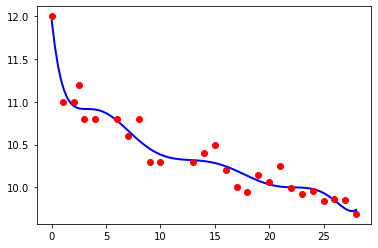

In [55]:
plt.plot(x_test,y_test,'b-',linewidth=2)
plt.plot(x,t,'ro')

This is the same as Figure 1.10 from *A First Course in Machine Learning*

In [48]:
train_predictions = regressor.predict(X)
train_mse = metrics.mean_squared_error(t,train_predictions)
print(train_mse)

0.04318491950082525


### Compare to simple linear regression model $y = w_0 + w_1x$

In [49]:
regressor = LinearRegression()
regressor.fit(x,t)

# print the intercept (w0)
print('w0 = ',regressor.intercept_)
  
# print the weight vector for the model (w1, w2, ...)
print('coefficients = ',regressor.coef_)

w0 =  [11.14109659]
coefficients =  [[-0.05332354]]


In [50]:
train_predictions_simple = regressor.predict(x)
train_mse_simple = metrics.mean_squared_error(t,train_predictions_simple)
print(train_mse_simple)

0.050307110475657925


### Generalisation and Overfitting

- The mean squared error for the degree 8 polynomial model is lower than the mean squared error of the linear model.
  - Does this mean it is a better model?

- Recall from last week what the aim of learning is: to generalise to *new, unseen* data.
- We have only calculated the mean squared error on data we have seen during training.
- Looking at the polynomial model of degree order 8, we can see that it makes very spurious predictions for future Olympic games (unseen data, whereas the straight line model seemed more reasonable.
- The polynomial model of degree 8 has much more flexibility than the straight line model: 
  - it is capable of replicating the straight line model by setting coefficients $w_2, w_3, \ldots $ to zero
  - by varying these weights (away from zero) however, it is capable of reducing the training cost further: when this happens too much, we are *over-fitting* to the training data 

## Validation data

- When we have trained a model, we should **validate** it, to ensure it generalizes well to unseen data (and isn't over-fitting to the training data)
- For this purpose, we use a second dataset called a **validation set**.
- The key property of the validation set is that it is *not seen during training*.
- The validation set is usually just a subset of our original dataset, that we set aside and accept won't be used for training.
  - The `train_test_split()` method from scikit learn can be used to split the original dataset into training and validation set for us.
- To choose between a set of potentials models, we train each one on the training set, and evaluate their loss on the validation set.
  - By 'loss', we mean some metric indicating the accuracy of the model. It may well be the same metric that was used fro training, just calculated on the validation set.
  


![FromSimpleToPoly](Images/FCML_Fig1_12_cite.png)

## Cross-validation

![FromSimpleToPoly](Images/FCML_Fig1_14_citec.png)

## Regularisation

Consider a polynomial model

\begin{equation}
 f(x) = w_0 + w_1x + w_2x^2 + w_3x^3 + w_4x^4 + w_5x^5
\end{equation}

- Generally, the larger the (absolute) values of the weights in the model, the more complex the model is.
- Large weights cause more drastic changes in the value of $f(x)$
  - For example, consider the derivative of $f$ with respect to $x$: the larger the weights, the larger the derivatives
- Therefore, one way to keep models simpler is to keep the absolute values of the parameters low. This is known as **regularisation**. 
- There are different ways to achieve regularisation, depending on how we capture model complexity.

### Ridge regression

- In **ridge regression** we capture model complexity by summing the squares of the model weights: $\sum_i w_i^2 = \mathbf{w}^T\mathbf{w}$
- We then adding this to our normal loss function (e.g. least squares) when training, i.e. we minimize:
  \begin{equation} \frac{1}{N} (\mathbf{y} - \mathbf{X}\mathbf{w})^T(\mathbf{y} - \mathbf{X}\mathbf{w}) + \lambda \mathbf{w}^T\mathbf{w}\end{equation}
- The parameter $\lambda$ (>0) controls the trade-off between model accuracy and model complexity:
  - If $\lambda$ is too small, then complex models are not penalized enough, and training favours high accuracy (potentially leading to over-fitting)
  - If $\lambda$ is too large, then simple models may be favoured too much during training, possibly leading to under-fitting (useful trends are not captured).
- A closed form expression exists for ridge regression (like the normal equations), but the problems exists as to how to set the value of $\lambda$. Usualy we use cross-validation to set its value.

### Hyperparameters

The parameter $\lambda$ in regularisation, and the maximum degree of polynomial in polynomial regression, are both examples of *hyperparameters*.  

Hyperparameters are parameters that cannot be optimized directly during training.  Instead another optimization procedure such as cross-validation is needed to determine the best values.

## Feature selection

- The weights in a linear model give an indication of the features they multiply.
- This can be used to simplify models: features with corresponding low weights may be removed from the model with little effect on accuracy.
- **Recursive feature elimination (RFE)** is recursively considers smaller and smaller sets of features. 
  - First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. 
  - Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.